# Custom Transformer

In [1]:
from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [2]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_state       1000 non-null   object
 1   seller_state         1000 non-null   object
 2   product_weight_g     1000 non-null   int64 
 3   product_length_cm    1000 non-null   int64 
 4   product_height_cm    1000 non-null   int64 
 5   product_width_cm     1000 non-null   int64 
 6   days_until_delivery  1000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 54.8+ KB


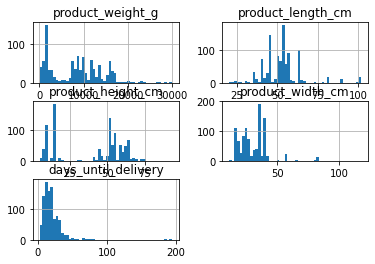

In [4]:
import matplotlib.pyplot as plt
data.hist(bins=50)
plt.show()

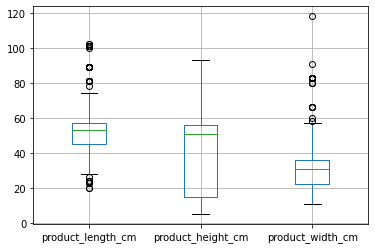

In [5]:
data.iloc[:, 3:-1].boxplot()
plt.show()

Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. The columns describe the size and weight of each item. The target is the number of days between the order and the delivery.

In [6]:
X = data.drop(columns='days_until_delivery')
y = data['days_until_delivery']

👇 In a pipeline:

- Engineer a 'volume' feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Train a default `Ridge` regression and cross_validate its score on the train set. Low r2 score are expected.

Use your pipeline to predict the delivery of the following order

In [7]:
from sklearn.preprocessing import FunctionTransformer

# Engineer a 'volume' feature from the dimensions features
volume = FunctionTransformer(lambda df: pd.DataFrame(df['product_length_cm'] 
                                                     * df['product_width_cm']
                                                     * df['product_height_cm']))


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [9]:
# Impute then Scale for numerical variables: 
volume_transformer = Pipeline([
    ('volume', volume),
    ('scaler', RobustScaler())
    ])

num_transformer = Pipeline([
    ('scaler', RobustScaler())
    ])

# Encode categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [10]:
# Apply transformations to desired features
preprocessor = ColumnTransformer([
    ('volume_transformer', volume_transformer, ['product_length_cm','product_width_cm','product_height_cm']),    
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64'])),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=['object']))
])



In [11]:
preprocessor

ColumnTransformer(transformers=[('volume_transformer',
                                 Pipeline(steps=[('volume',
                                                  FunctionTransformer(func=<function <lambda> at 0x126de53a0>)),
                                                 ('scaler', RobustScaler())]),
                                 ['product_length_cm', 'product_width_cm',
                                  'product_height_cm']),
                                ('num_transformer',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x126f97ee0>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x126f97f40>)])

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head(3)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.975552,-0.815348,-2.750000,-1.097561,-1.357143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.170856,-0.011223,-0.916667,0.317073,0.928571,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.718822,0.127098,0.166667,0.317073,-0.285714,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
from sklearn.linear_model import Ridge

In [15]:
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_regressor', Ridge())
])
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('volume_transformer',
                                                  Pipeline(steps=[('volume',
                                                                   FunctionTransformer(func=<function <lambda> at 0x126de53a0>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['product_length_cm',
                                                   'product_width_cm',
                                                   'product_height_cm']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x126f97ee0>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x126f97f40>)])),
                ('linear_regressor', Ridge())])

In [16]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('volume_transformer',
                                                  Pipeline(steps=[('volume',
                                                                   FunctionTransformer(func=<function <lambda> at 0x126de53a0>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['product_length_cm',
                                                   'product_width_cm',
                                                   'product_height_cm']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x126f97ee0>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x126f97f40>)])),
                ('linear_regressor', Ridge())])

In [17]:
final_pipe.predict(X_test);

In [18]:
final_pipe.score(X_test, y_test)

0.18093012514597373

In [19]:
cross_val_score(final_pipe, X_train, y_train, cv=5).mean()

0.15724928751608422

In [20]:
new_data = pd.read_csv("data_new.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [21]:
final_pipe.predict(new_data)

array([21.08305159])

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look wierd, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse=True)`. Use `.todense()` to turn it back to a dense matrix

</details>